In [2]:
import csv
import geojson
import folium
import pytz
import os
import pandas as pd
import multiprocessing as mp

from datetime import datetime
from collections import defaultdict
from matplotlib import pyplot as plt
from __future__ import print_function

project_path = '/mnt/c/Users/cephei/Desktop/notebooks/stop_uses_by_route'

# SQL para extraer datos de la base de datos

In [3]:
# ingresar a la shell de postgres
#python manage.py dbshell

# obtener datos de nearbybuses_log y guardarlos en un csv
#\copy (select * from "AndroidRequests_nearbybuseslog" where "timeStamp" > '2018-10-22 00:00:00') To '/tmp/nearbybuseslog.csv' WITH CSV DELIMITER ',' HEADER;

# obtener localización de paraderos
#\copy (select distinct code, latitude, longitude from gtfs_busstop) To '/tmp/stops.csv' HEADER;

# Cargar posición de paraderos

In [4]:
stop_info_path = os.path.join(project_path, 'stops.csv')

stop_locations = {}
with open(stop_info_path, 'r', encoding='utf-8-sig') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',')
    for row in spamreader:
        stop_locations[row['code']] = [float(row['latitude']), float(row['longitude'])]
        
print('{0} stops'.format(len(stop_locations)))

11709 stops


# Cargar archivo con secuencia de paradas por servicio

In [7]:
route_info_path = os.path.join(project_path, 'v1.9', 'phone', 'route.csv')

stop_by_route = defaultdict(lambda: dict(i=None, r=None))
with open(route_info_path, 'r', encoding='windows-1252') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=';')
    for row in spamreader:
        stop_by_route[row['service']]['I'] = row['stopsI'].split('-')
        stop_by_route[row['service']]['R'] = row['stopsR'].split('-')

print('route number: {0}'.format(len(stop_by_route)))

route number: 397


# Función para procesar archivo de consultas a paraderos

In [8]:
nearbybuses_log_path = os.path.join(project_path, 'nearbybuseslog.csv')

def process_frame(df, stop_code_list, lower_threshold, upper_threshold):
    # process data frame
    
    condition = (lower_threshold <= df.timeStamp) & (df.timeStamp <= upper_threshold)
    # if is None ignore stop filter
    if stop_code_list is not None:
        condition = df.stopCode.isin(stop_code_list) & condition
    
    return df[condition]

def process_stop_data(stop_code_list, bucket, lower_threshold, upper_threshold):
    CHUNKSIZE = 1000000
    reader = pd.read_csv(nearbybuses_log_path, chunksize=CHUNKSIZE, sep=',', parse_dates=[0], 
                         usecols=['timeStamp', 'stopCode', 'phoneId'])
    pool = mp.Pool(4) # use 4 processes

    funclist = []

    for df in reader:
        # process each data frame
        print('p ', end='')
        f = pool.apply_async(process_frame, [df, stop_code_list, lower_threshold, upper_threshold])
        funclist.append(f)

    # concat dataframe
    df_filtered = []
    for f in funclist:
        df_filtered.append(f.get())
        print('f ', end='')
    print('')
    pool.close()

    print('concat df ....')
    new_df = pd.concat(df_filtered)
    print('applying format to timeStamp column...')
    new_df.timeStamp = new_df.timeStamp.map(lambda x: x.replace(**bucket))
    print('calculating number of user by timeStamp field...')

    df_group = new_df.groupby(['stopCode', 'timeStamp'])
    print('min users: {0}'.format(df_group.phoneId.nunique().min()))
    print('max users: {0}'.format(df_group.phoneId.nunique().max()))
    print('distinct user number: {0}'.format(new_df.phoneId.nunique()))
    # lista de phone-ids
    print(new_df.phoneId.unique().tolist())

    return new_df

# Procesar log de consultas a paradas
### calcula el número de personas que consultó una o más paradas por día

In [15]:
# para agrupar por año, mes, día, hora, segundo, etc...
bucket = dict(day=1, hour=0, minute=0, second=0, microsecond=0)
# periodo a evaluar
lower_threshold = datetime(2018, 10, 1)
upper_threshold = datetime(2020, 12, 2)

# paraderos que se van a evaluar en el gráfico
route_codes = {
    'B07': ['R'], 
    'B13': ['I'], 
    'B08': ['R'],
}
stop_codes = []
for route_code in route_codes:
    if route_code not in stop_by_route:
        raise ValueError("Servicio {0} no existe!".format(route_code))
    for direction in route_codes[route_code]:
        stop_codes += stop_by_route[route_code][direction]
        print('servicio {0}-{1} tiene paradros: {2}'.format(route_code, direction, len(stop_codes)))

# 315c R
stop_codes += ['PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666','PB1885','PB1240','PB1241','PB493','PB1242','PB945','PB572','PB573','PB649','PB650','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666']
# 307c R
stop_codes += ['PB1885','PB622','PB556','PB557','PB558','PB559','PB560','PB561','PB562','PB563','PB564','PB565','PB566','PB567','PB568','PB1595','PB1665','PB1666']
# 308c 
stop_codes += ['PB549','PB550','PB551','PB454','PB455','PB456','PB520','PB521','PB522','PB592','PB593','PB594','PB595','PB596','PB597','PB598','PB599','PB568']
               
df_result = process_stop_data(stop_codes, bucket, lower_threshold, upper_threshold)


servicio B13-I tiene paradros: 48
servicio B08-R tiene paradros: 90
servicio B07-R tiene paradros: 123
p p p p p p p p p p p p p f f f f f f f f f f f f f 
concat df ....
applying format to timeStamp column...
calculating number of user by timeStamp field...
min users: 1
max users: 108
distinct user number: 1712
['67e08742-45cd-4a65-9313-a10d5447394e', '5c64e44b-34e3-406e-af4e-f71f124baadb', 'd52317fe-3227-49a8-b483-d66845a7d474', '74ef568b-e3d4-4259-bba1-77710a3f9642', '5d146021-1b9a-4126-b309-3c7ba5825918', '269e2a7d-2f45-4d28-b799-2246afd4bbfd', '7907b257-ce49-4cb5-97e2-8fef7a88e342', '054b81c2-5ca0-4638-8f3f-fdbb39ce1c8e', '48e9fa6d-caa7-4709-b5fe-592aa1b5e002', '06161ec0-766c-455d-bdf8-099ffbc3d4c6', '4eb628a1-98e2-4c6a-ac1d-aa9965194538', '08bc23de-6c05-405f-9f56-a62f3cda9bd6', '39fcb915-7abc-4c76-a84c-e93c71775c68', 'edb0bddd-ba0d-446a-a7a5-81e9b63e667d', 'b341e33b-d30f-4fb6-bb25-a06a5a3935c3', 'f6b5b3fe-3a4c-4508-af8e-a44c67065812', '9935e70a-ac1d-495d-a5dc-8e428e3a1ea0', '98c0

# Uso de uno o más paraderos por día

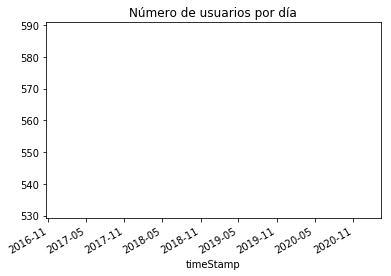

<Figure size 432x288 with 0 Axes>

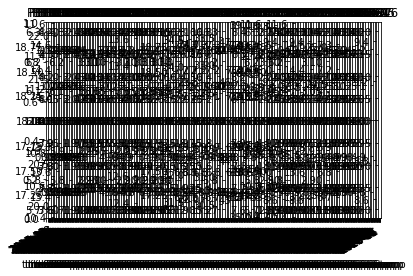

In [13]:
plt.figure(1)
# usuarios distintos por día
df_result.groupby(['timeStamp']).phoneId.nunique().plot(y='phoneId', title='Número de usuarios por día')#, ax=axs[0])

plt.figure(2)
# usuarios por paradero
groupby_stopcode = df_result.groupby(['stopCode'])

fig, axs = plt.subplots(1, len(groupby_stopcode) + 1)
plt.rcParams["figure.figsize"] = (25,2)

for index, (label, df) in enumerate(groupby_stopcode):
    subgroup_df = df.groupby(['timeStamp']).phoneId.nunique()
    subgroup_df.plot(x='timeStamp', y='phoneId', title=label, color='blue', ax=axs[index + 1]);

# construir archivo para kepler

In [33]:
output_path = os.path.join(project_path, 'salida.csv')

header = ['stop_code', 'stop_lat', 'stop_lon', 'timestamp', 'user_number']

stop_error = set()
with open(output_path, 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(header)
    for stop_code in numb_by_hour.keys():
        for timestamp in numb_by_hour[stop_code].keys():
            try:
                request_number = numb_by_hour[stop_code][timestamp]
                row = [stop_code] + stop_locations[stop_code] + [timestamp, request_number]
                spamwriter.writerow(row)
            except KeyError:
                stop_error.add(stop_code)
print('{0} paraderos sin posición'.format(len(stop_error)))

0 paraderos sin posición


# Procesar shapes de GTFS

In [34]:
import time

from geojson import LineString, MultiLineString, Feature
from IPython import display

gtfs_shapes_path = os.path.join(project_path, 'v1.7', 'phone', 'shape.csv')

route_codes = ['{0}{1}'.format(route_code, direction)]

routes = defaultdict(list)

with open(gtfs_shapes_path, 'r') as csv_file:
    spamreader = csv.DictReader(csv_file, delimiter=';')
    for row in spamreader:
        route = row['id'].upper()
        
        if route in route_codes:
            lon_lat = (float(row['longitud']), float(row['latitud']))
            routes[route].append(lon_lat)

shapes = []
for route in routes:
    route_shape = routes[route]

    if False:
        # ====================================
        beauchef_location = [-33.455328, -70.6682527]
        zoom = 11
        m = folium.Map(location=beauchef_location, zoom_start=zoom)
        _shape = LineString(route_shape)
        folium.GeoJson(_shape, name='geojson').add_to(m)

        display.clear_output(wait=True)
        display.display(route_number, row['shape_id'])
        display.display(m)
        time.sleep(1.0)
        # ========================================
    shapes.append(route_shape)

collection = MultiLineString(shapes)
collection = Feature(geometry=collection, properties={'color': '#148EA5'})

# Guardar shape en un archivo

In [35]:
from geojson import dumps as geojson_dumps
shape_path = os.path.join(project_path, 'shapes.geojson')

with open(shape_path, 'w') as shape_file:
    shape_file.write(geojson_dumps(collection))

# Revisar shape generado

In [36]:
import geojson
from folium.features import CustomIcon

beauchef_location = [-33.455328, -70.6682527]
zoom = 11
m = folium.Map(location=beauchef_location, zoom_start=zoom)

folium.GeoJson(collection, name='geojson').add_to(m)

icon_image = 'http://200.9.100.91/onlinegps/static/img/paradero.png'

for stop_code in stop_codes:    
    stop_icon = CustomIcon(icon_image, icon_size=(32, 48), icon_anchor=(16, 48), popup_anchor=(0, -48))
    folium.Marker(location=stop_locations[stop_code], icon=stop_icon, popup='<i>{0}</i>'.format(stop_code)).add_to(m)

m